### Imports

In [2]:
import pandas as pd 
import seaborn as sns 
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy

### Generate test data

In [102]:
#This function generates test data for stars with ra, dec and magnitude for "plate" data and "gaia" data

random.seed(1)
n = 1000 #number of stars 10
r_apt = 100 #number of stars removed from apt 4
r_gaia = 10 #number of stars removed from gaia 2
i = 0
dt = [] #ideal
dt1 = [] #plate(apt)
dt2 = [] #"truth" (gaia)
er = 0.1 #deviation from "ideal" data

#for same number of stars
while i < n:
    dt.append([round(random.uniform(50,100), 2),round(random.uniform(50,100), 2),round(random.uniform(5,15), 2)])
    dt1.append([(dt[i][0]-round(random.uniform(-er,er), 2)), (dt[i][1]-round(random.uniform(-er,er), 2)), \
                (dt[i][2]-round(random.uniform(-er,er), 2))])
    dt2.append([(dt[i][0]-round(random.uniform(-er,er), 2)), (dt[i][1]-round(random.uniform(-er,er), 2)), \
                (dt[i][2]-round(random.uniform(-er,er), 2))])
    i+=1

df_apt = pd.DataFrame(dt1, columns = ['CentroidRA', 'CentroidDec', 'Magnitude'])
df_gaia = pd.DataFrame(dt2, columns = ['ra', 'dec','phot_bp_mean_mag']) 

drop_indices = np.random.choice(df_apt.index, r_apt, replace=False)
df_apt = df_apt.drop(drop_indices).reset_index(drop=True)
drop_indices = np.random.choice(df_gaia.index, r_gaia, replace=False)
df_gaia = df_gaia.drop(drop_indices).reset_index(drop=True)

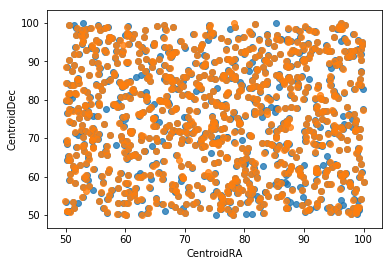

In [103]:
sns.regplot('ra','dec',data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec',data=df_apt, fit_reg = False)

### Process data
- Combine data based on similarities between ra&dec
- Create new combined data
- Delete overlapping terms
- https://stackoverflow.com/questions/13079563/how-does-condensed-distance-matrix-work-pdist

In [104]:
maxdiff = 400
querystr = "diff<" + str(maxdiff)
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','CentroidRA','CentroidDec','Magnitude','diff'])
dist = scipy.spatial.distance.cdist(df_apt[['CentroidRA', 'CentroidDec']], df_gaia[['ra', 'dec']]) #6, 8
min_dist = np.argmin(dist, axis=1) #8

m = 0
while m < len(df_apt): #apt (6)
    n = min_dist[m]    #gaia (8)
    df = df.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n],\
                    'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n],\
                    'CentroidRA': df_apt['CentroidRA'][m],'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': dist[m][n]
                   }, ignore_index=True)
    m+=1


df = df.query(querystr)
#df = df.sort_values('diff').drop_duplicates('ra')
#df = df.sort_values('diff').drop_duplicates('CentroidRA')
#df= df.reset_index(drop=True)

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

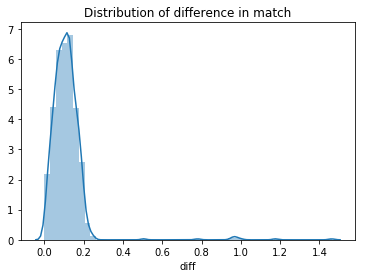

In [105]:
#Check match
sns.distplot(df['diff']).set_title('Distribution of difference in match')

In [106]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 

#subset
df_filtered = df.query('diff<0.2')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'dec vs. Δdec')

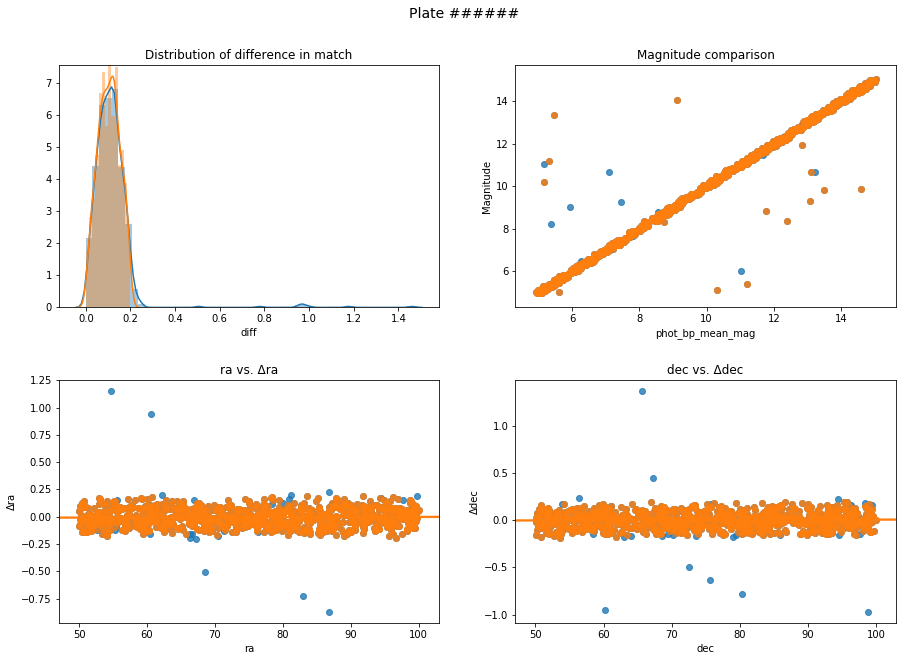

In [107]:
#plots
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate ######", fontsize=14)
fig.subplots_adjust(top=0.9, wspace=0.2, hspace = 0.3)
ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
sns.distplot(df_filtered['diff'])
ax2 = fig.add_subplot(2,2,2)
sns.regplot('phot_bp_mean_mag','Magnitude',data=df, fit_reg = False).set_title('Magnitude comparison')
sns.regplot('phot_bp_mean_mag','Magnitude',data=df_filtered, fit_reg = False).set_title('Magnitude comparison')
ax3 = fig.add_subplot(2,2,3)
sns.regplot('ra','Δra',data=df, fit_reg = False).set_title('ra vs. Δra')
sns.regplot('ra','Δra',data=df_filtered).set_title('ra vs. Δra')
ax4 = fig.add_subplot(2,2,4)
sns.regplot('dec','Δdec',data=df, fit_reg = False).set_title('dec vs. Δdec')
sns.regplot('dec','Δdec',data=df_filtered).set_title('dec vs. Δdec')